In [1]:
import os
import re
import pywt
import glob
import joblib
import numpy as np
import pandas as pd 
from scipy import interpolate

import matplotlib.pyplot as plt

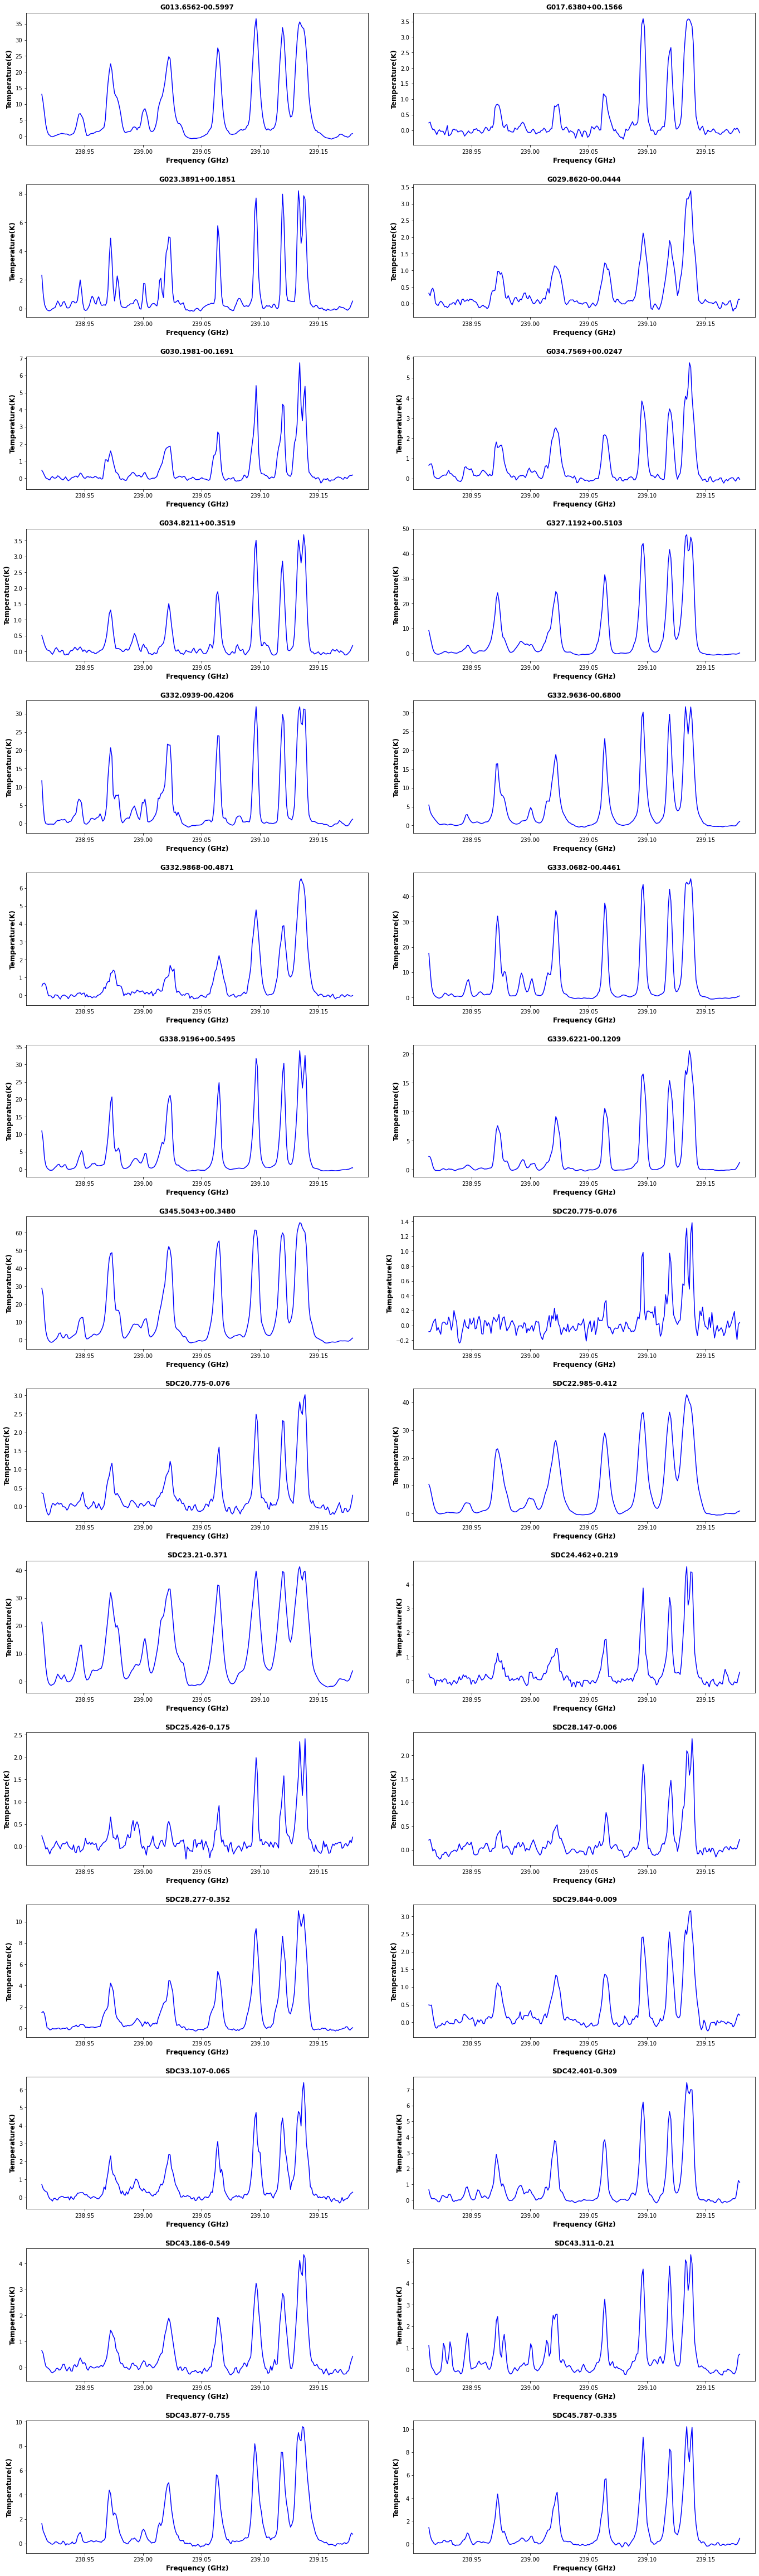

In [2]:
CH3CN_DATA_PATH = 'data/observational/ch3cn_spec/'
CH3CH_DATA_OUTPUT_PATH = 'data/observational/ch3cn_output/'
C3CHN_GENERATED_FILES_OUTPUT_PATH = 'data/observational/ch3cn_generated_files/'

# open the file in the data path
# df_ch3cn = pd.read_csv(ch3cn_data_path + 'G017.6380+00.1566_SPW_0_p_spec.dat', delim_whitespace=True)

unwanted_file_list = ['G050.2213-00.6063_SPW_0_p_spec.dat', 'G326.6618+00.5207_SPW_0_p_spec.dat', 'SDC24.381-0.21_3_SPW_0_p_spec.dat', 
                'SDC18.816-0.447_1_SPW_0_p_spec.dat', 'SDC35.063-0.726_1_SPW_0_p_spec.dat', 'SDC45.927-0.375_2_SPW_0_p_spec.dat', 
                'SDC37.846-0.392_1_SPW_0_p_spec.dat', 'SDC30.172-0.157_2_SPW_0_p_spec.dat',  'SDC18.816-0.447_1_SPW_0_p_spec.dat'               
]

def plot_observational_data(CH3CN_DATA_PATH):
    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop files whose intensity column highest value is in the range of [0, 0.6]
    # ch3cn_files = [file for file in ch3cn_files if float(pd.read_csv(file, delim_whitespace=True, nrows=1).iloc[0, -2]) > 0.5]
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=15, ncols=2, figsize=(20, 65))
    fig.tight_layout(pad=5)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= 238.600) & (df_ch3cn['RestFreq(GHz)'] <= 239.180)]
        # drop the spectra with T(K) in the range of 0 to 0.4
    

        # print(df_ch3cn['RestFreq(GHz)'].min(), df_ch3cn['RestFreq(GHz)'].max())

        # print the length for each file
        # print(f'{file} has {len(df_ch3cn)} rows')
    
        # plot the data
        axn.plot(df_ch3cn['RestFreq(GHz)'], df_ch3cn['T(K)'], color='blue')
        axn.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=12, fontweight='bold')
        axn.set_title(file.split('/')[-1].split('_')[0], fontsize=12, fontweight='bold')

plot_observational_data(CH3CN_DATA_PATH)
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'ch3cn_spec.pdf', dpi=15000)   

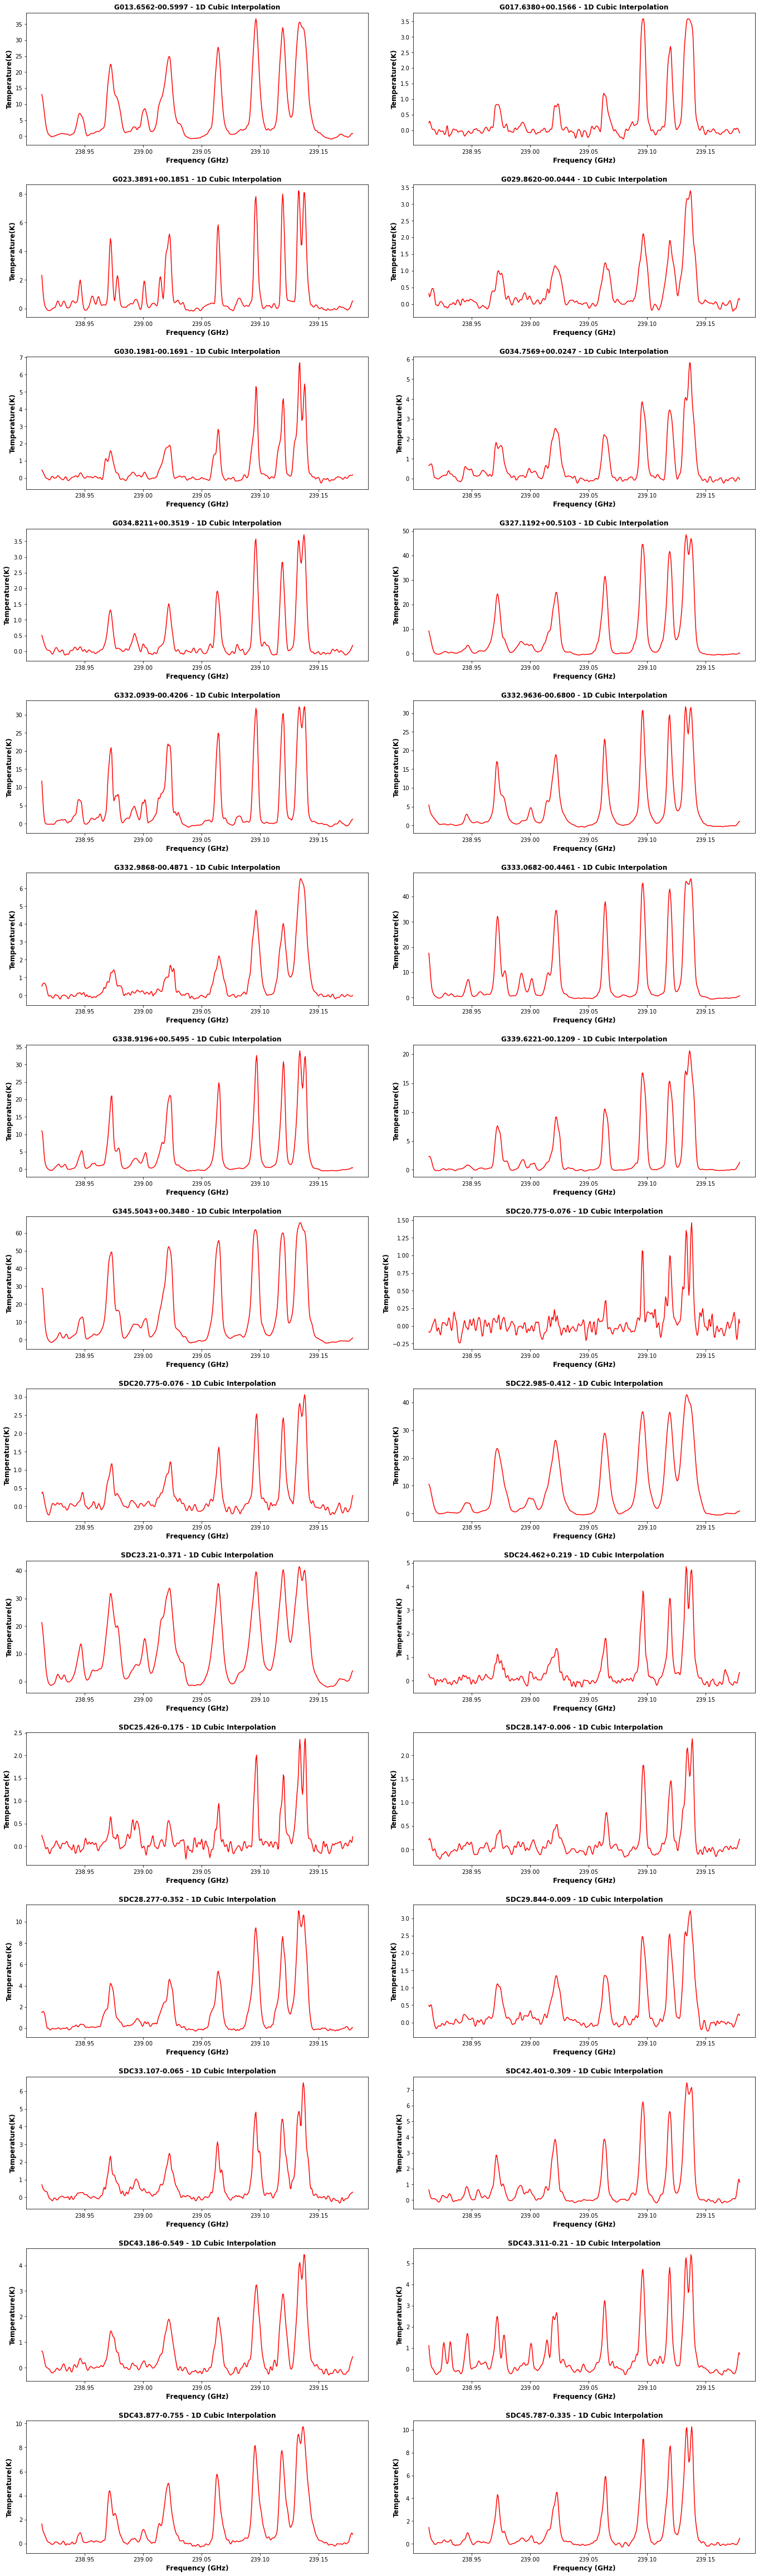

In [3]:
def interpolate_observational_data(CH3CN_DATA_PATH):
    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=15, ncols=2, figsize=(20, 65))
    fig.tight_layout(pad=5)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= 238.60) & (df_ch3cn['RestFreq(GHz)'] <= 239.18)]

        x = df_ch3cn['RestFreq(GHz)']
        y = df_ch3cn['T(K)']

        # new length of the data to match the number of features used in the model
        new_length = 454
        # new x values
        new_x = np.linspace(x.min(), x.max(), new_length)
        # new y values
        new_y = interpolate.interp1d(x, y, kind='cubic')(new_x)
        # print(f'{file} has {len(new_y)} rows')

        # plot the data
        axn.plot(new_x, new_y, color='red')
        axn.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=12, fontweight='bold')
        axn.set_title(file.split('/')[-1].split('_')[0] + ' - 1D Cubic Interpolation', fontsize=12, fontweight='bold')


interpolate_observational_data(CH3CN_DATA_PATH)
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'ch3cn_spec_1D_interpolation.pdf', dpi=15000)
    

In [4]:
# get model path and load the model
model_path = 'data/models/'

rf_model = joblib.load(os.path.join(model_path + 'rf_model.pkl'))
xgb_model = joblib.load(os.path.join(model_path + 'xgb_model.pkl'))
xgb_tuned_model = joblib.load(os.path.join(model_path, 'xgb_tuned_model.pkl'))

test_model = joblib.load(os.path.join(model_path + 'test_xgb_tuned_model.pkl'))
test_20k_model = joblib.load(os.path.join(model_path + 'test_20k_xgb_tuned_model.pkl'))


/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


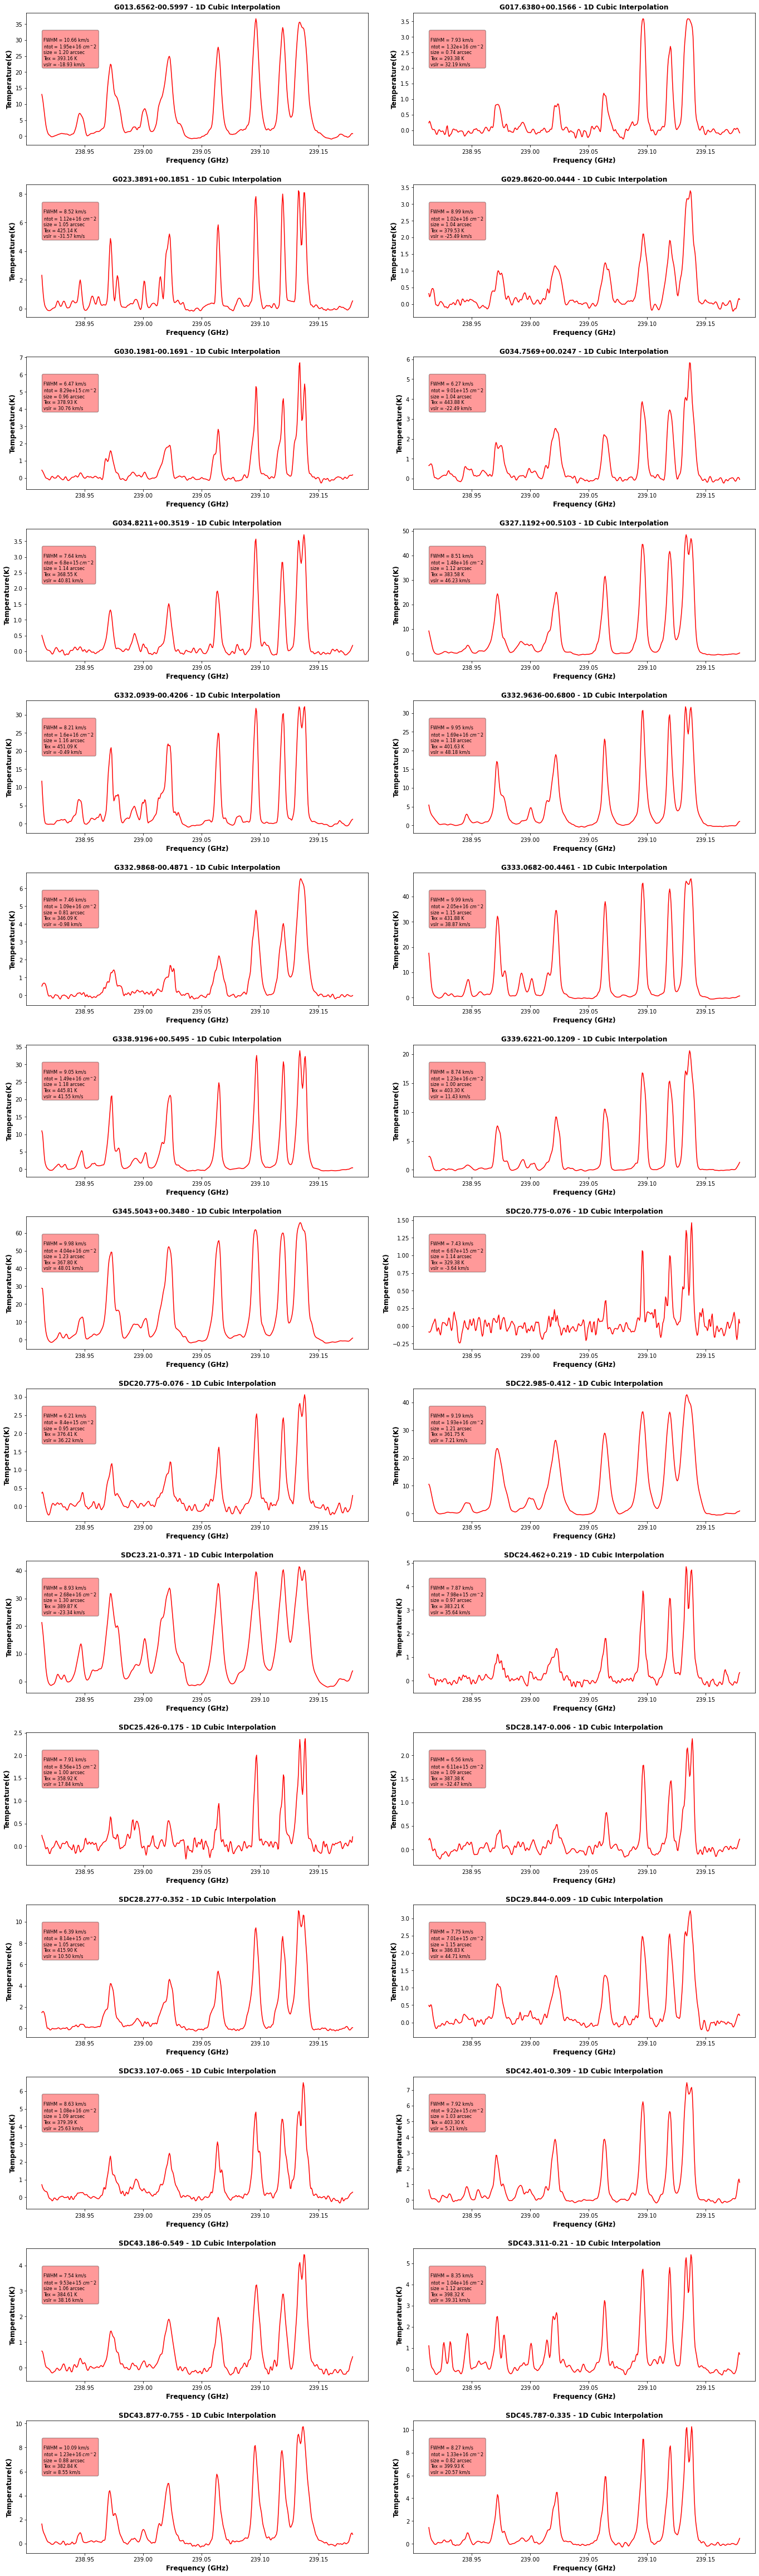

In [5]:
def predict_ch3cn_parameters(model, CH3CN_DATA_PATH):

    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=15, ncols=2, figsize=(20, 65))
    fig.tight_layout(pad=5)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= 238.60) & (df_ch3cn['RestFreq(GHz)'] <= 239.18)]

        x = df_ch3cn['RestFreq(GHz)']
        y = df_ch3cn['T(K)']

        # new length of the data
        new_length = 454
        # new x values
        new_x = np.linspace(x.min(), x.max(), new_length)
        # new y values
        new_y = interpolate.interp1d(x, y, kind='cubic')(new_x)

        # use the model to predict the parameters for the ch3cn model get the predicted parameters
        predicted_params = model.predict(new_y.reshape(1,-1))
        # save the predicted parameters to a dataframe
        df_predicted_parameters = pd.DataFrame(predicted_params, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
        df_predicted_parameters['ntot'] = np.array(10**df_predicted_parameters['ntot']) # convert the ntot to linear scale
        
        # plot the interpolated data 
        axn.plot(new_x, new_y, color='red')
        axn.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=12, fontweight='bold')
        axn.set_title(file.split('/')[-1].split('_')[0] + ' - 1D Cubic Interpolation' , fontsize=12, fontweight='bold')
        
        
        params = df_predicted_parameters.iloc[0]
        params = '\nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arcsec \nTex = {:.2f} K \nvslr = {:.2f} km/s'.format(params['fwhm'], params['ntot'], params['size'], params['tex'], params['vlsr'])
        # add a text box with the predicted parameters for each subplot corresponding to each file
        plt.text(0.05, 0.6, params, transform=axn.transAxes, color='black', bbox = dict(boxstyle='round', facecolor = 'red', alpha = 0.4),  fontsize=8)    

predict_ch3cn_parameters(xgb_tuned_model, CH3CN_DATA_PATH)
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'xgb_tuned_ch3cn_predicted_params.pdf', dpi=15000)
    

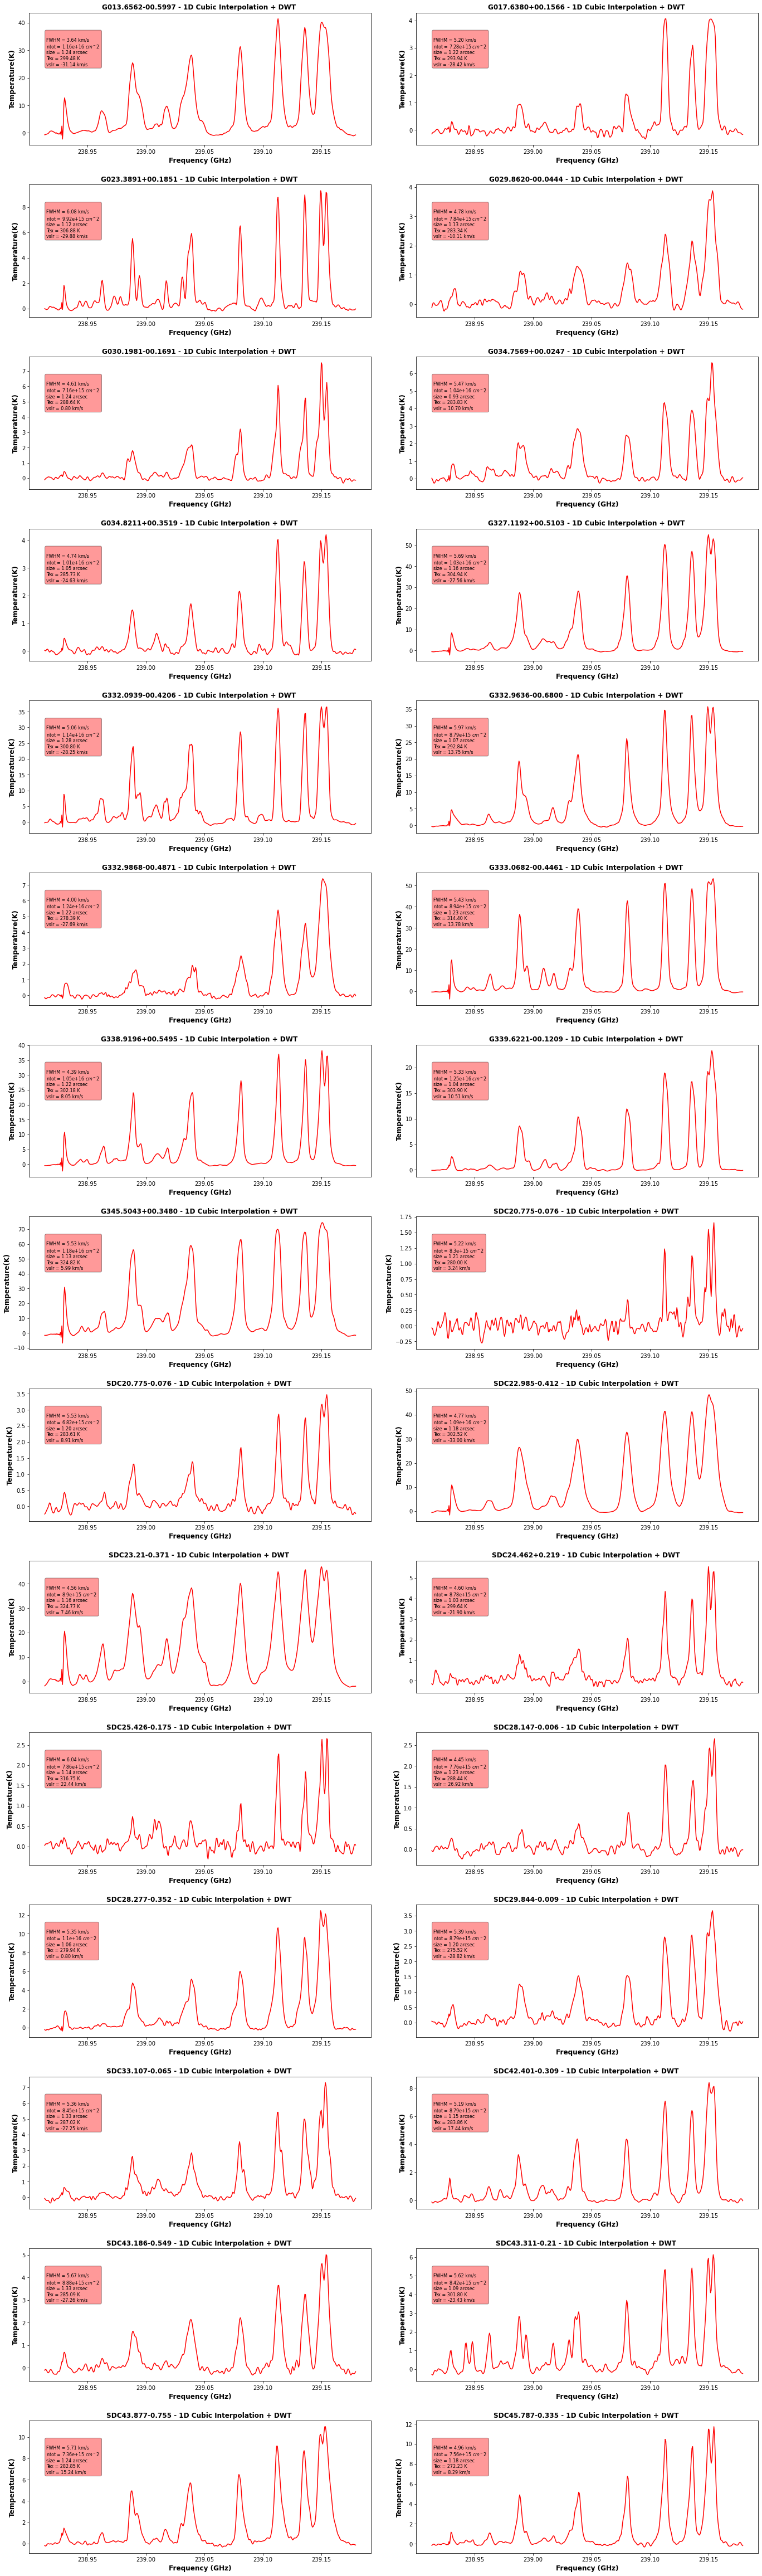

In [6]:
def dwt_observational_data(CH3CN_DATA_PATH, model):

    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=15, ncols=2, figsize=(20, 65))
    fig.tight_layout(pad=5)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= 238.60) & (df_ch3cn['RestFreq(GHz)'] <= 239.18)]

        x = df_ch3cn['RestFreq(GHz)']
        y = df_ch3cn['T(K)']
        
        xx_new_lenghth = 454
        xx = x.values
        # yy = y.values
        xx_new = np.linspace(xx.min(), xx.max(), xx_new_lenghth)
        # yy_new = interpolate.interp1d(xx, yy, kind='cubic')(xx_new)

        # new length of the data
        new_length = 58000
        # new x values
        new_x = np.linspace(x.min(), x.max(), new_length)
        # new y values
        new_y = interpolate.interp1d(x, y, kind='cubic')(new_x)

        detail_coeffs = np.zeros((len(new_y), 454))
        approx_coeffs = np.zeros((len(new_y), 454))
        
        # denoise the data using the wavelet transform to get the wavelet coefficients
        coeffs = pywt.wavedec(new_y, 'db36', mode='per',  level=7)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        # get the detail coefficients
        detail_coeffs = coeff_arr[coeff_slices[1]['d']]
        # get the approximated coefficients
        approx_coeffs = coeffs[0]


        # print(len(approx_coeffs))

        # use the model to predict the parameters for the ch3cn model and get the predicted parameters
        predicted_parameters = model.predict(detail_coeffs.reshape(1,-1))
        # save the predicted parameters to a dataframe
        df_predicted_parameters = pd.DataFrame(predicted_parameters, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
        df_predicted_parameters['ntot'] = np.array(10**df_predicted_parameters['ntot']) # convert the ntot to linear scale

        # plot the interpolated data 
        axn.plot(xx_new, approx_coeffs/10, color='red')
        axn.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=12, fontweight='bold')
        axn.set_title(file.split('/')[-1].split('_')[0] + ' - 1D Cubic Interpolation + DWT ', fontsize=12, fontweight='bold')
        
        
        params = df_predicted_parameters.iloc[0]
        params = '\nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arcsec \nTex = {:.2f} K \nvslr = {:.2f} km/s'.format(params['fwhm'], params['ntot'], params['size'], params['tex'], params['vlsr'])
        plt.text(0.05, 0.6, params, transform=axn.transAxes, color='black', bbox = dict(boxstyle='round', facecolor = 'red', alpha = 0.4),  fontsize=8)

dwt_observational_data(CH3CN_DATA_PATH, xgb_tuned_model)
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'xgb_tuned_ch3cn_interpolation_dwt.pdf', dpi=15000)

#### Signal Denoising with DWT

The denosing algorithm is based in the following steps:

1. Apply the dwt to the signal.
2. Compute the threshold corresponding to the chosen level, see [phd thesis](https://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf)
3. Only keep coefficients with a value higher than the threshold
3. Apply the inverse dwt to retrieve the signal, i.e., the reconstructed signal.

Code (some parts) implementation from: [kaggle](https://www.kaggle.com/code/jpandeinge/denoising-with-direct-wavelet-transform)


The Mean Absolute Deviation (MAD) is a measure of dispersion. It is given by:

    MAD = 1\N * sum(|x_i - x_mean|)

where `x_i` is the i-th element of the signal, and `x_mean` is the mean of the signal.

In [7]:
def madev(coeff_data, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(coeff_data - np.mean(coeff_data, axis)), axis)

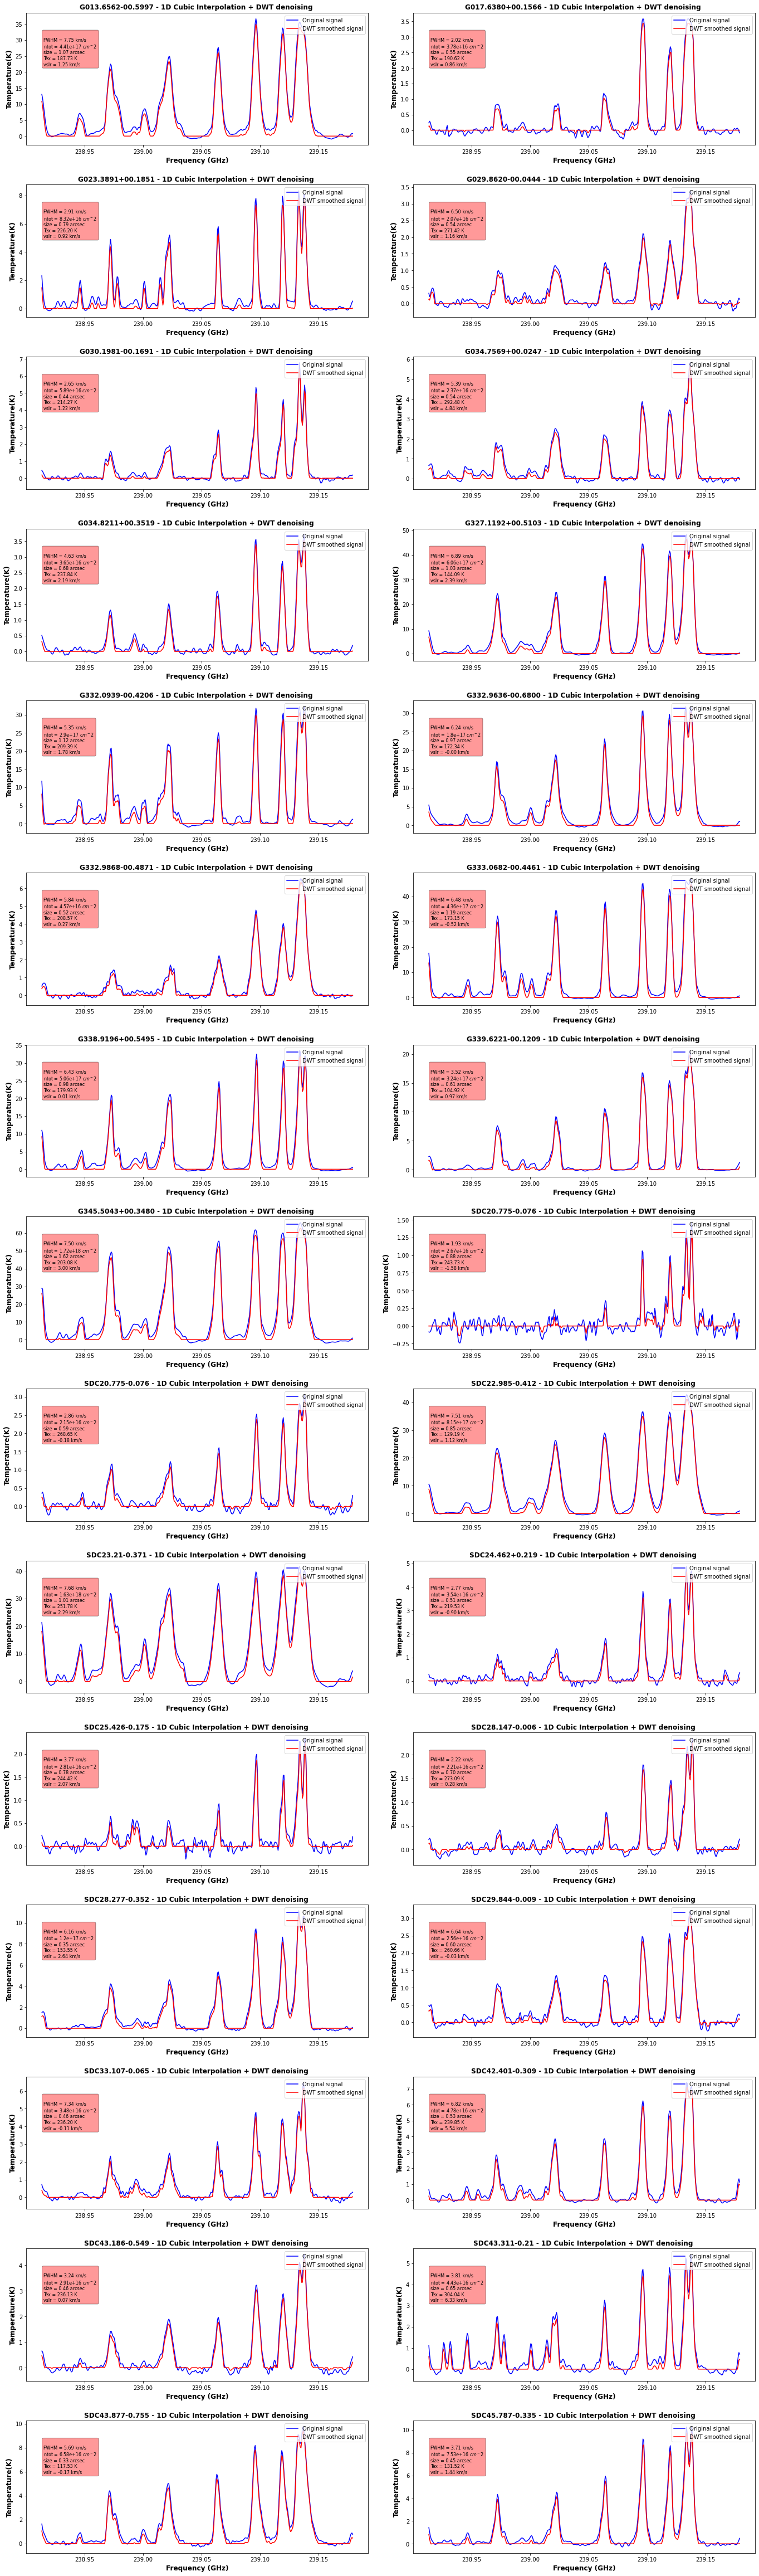

In [8]:
def denoise_observational_data(CH3CN_DATA_PATH, model, filename):

    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=15, ncols=2, figsize=(20, 65))
    fig.tight_layout(pad=5)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= 238.60) & (df_ch3cn['RestFreq(GHz)'] <= 239.18)]
        # row_one_vals = pd.DataFrame({"RestFreq(GHz)": 238.60, "T(K)": 0.0}, index=[0])
        # df_ch3cn = pd.concat([df_ch3cn.iloc[:0], row_one_vals, df_ch3cn.iloc[0:]]).reset_index(drop=True)


        x = df_ch3cn['RestFreq(GHz)']
        y = df_ch3cn['T(K)']
        # print(x)


        # new length of the data to match the length of the synthetic data
        new_length = 27000
        # new x values
        new_x = np.linspace(x.min(), x.max(), new_length)
        # new y values
        new_y = interpolate.interp1d(x, y, kind='cubic')(new_x)

        detail_coeffs = np.zeros((len(new_y), 422))
        approx_coeffs = np.zeros((len(new_y), 422))
    
        # denoise the data using the wavelet transform and get the wavelet coefficients
        level = 6
        coeffs = pywt.wavedec(new_y, 'db1', mode='per',  level=level)
        # calculate sigma of the coefficients
        sigma = (1/0.6745) * madev(coeffs[-level])
        # calculate the threshold
        threshold_value = sigma * np.sqrt(2*np.log(len(new_y)))
        coeffs[1:] = (pywt.threshold(i, value=threshold_value, mode="hard" ) for i in coeffs[1:]) # apply the threshold to the detail coefficients
        coeffs[0] = pywt.threshold(coeffs[0], value=threshold_value, mode="soft") # apply the threshold to the approximated coefficients
        # assign the denoised approximation coefficients to a new variable
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        reconstructed_signal = pywt.waverec(coeffs, 'db1', mode="per")

        # get the detail coefficients
        detail_coeffs = coeff_arr[coeff_slices[1]['d']]
        # get the approximated coefficients
        approx_coeffs = coeffs[0]

        # interpolate the reconstructed signal to have 454 points
        xx_new_length = 422
        xx = x.values
        xx_new = np.linspace(xx.min(), xx.max(), xx_new_length)
        # interpolate the original signal to have 454 points
        new_yy = interpolate.interp1d(x, y, kind='cubic')(xx_new)
        # interpolate the denoised data to have 454 points
        yy_new = interpolate.interp1d(new_x, reconstructed_signal, kind='cubic')(xx_new)
        
        # use the model to predict the parameters for the ch3cn model and get the predicted parameters
        predicted_parameters = model.predict(np.array(approx_coeffs).reshape(1,-1))
        # save the predicted parameters to a dataframe
        df_predicted_parameters = pd.DataFrame(predicted_parameters, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
        df_predicted_parameters['ntot'] = np.array(10**df_predicted_parameters['ntot']) # convert the ntot to linear scale
        # get a dataframe with the predicted parameters + the file name without the .dat extension
        df_predicted_parameters['filename'] = os.path.basename(file).replace('.dat', '')
    
        # df_predicted_parameters['filename'] = file.split('/')[-1]

        # save the predicted parameters to a csv file by appending the data for each file to the existing file
        df_predicted_parameters.to_csv(C3CHN_GENERATED_FILES_OUTPUT_PATH + filename, mode='a', header=False,  index=False)
        
        

        # plot the interpolated data 
        axn.plot(xx_new, new_yy, color='blue', label='Original signal')
        axn.plot(xx_new, yy_new, color='red', label='DWT smoothed signal')
        axn.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=12, fontweight='bold')
        axn.set_title(file.split('/')[-1].split('_')[0] + ' - 1D Cubic Interpolation + DWT denoising ', fontsize=12, fontweight='bold')
        axn.legend(loc='upper right')
        
        
        params = df_predicted_parameters.iloc[0]
        params = '\nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arcsec \nTex = {:.2f} K \nvslr = {:.2f} km/s'.format(params['fwhm'], params['ntot'], params['size'], params['tex'], params['vlsr'])
        plt.text(0.05, 0.6, params, transform=axn.transAxes, color='black', bbox = dict(boxstyle='round', facecolor = 'red', alpha = 0.4),  fontsize=8)

denoise_observational_data(CH3CN_DATA_PATH, test_20k_model, 'test_20k_xgb_tuned_ch3cn_predicted_parameters.csv')
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'rf_ch3cn_interpolation_dwt_denosing.pdf', dpi=15000)

### Reconstruction of Observational Data From Predictions

In [9]:
RF_RECONSTRUCTED_PATH = 'data/observational/ch3cn_reconstructed/rf/'
XGB_RECONSTRUCTED_PATH = 'data/observational/ch3cn_reconstructed/xgb/'
XGB_TUNED_RECONSTRUCTED_PATH = 'data/observational/ch3cn_reconstructed/xgb_tuned/'

TEST_RECONSTRUCTED_PATH = 'data/observational/ch3cn_reconstructed/test/'

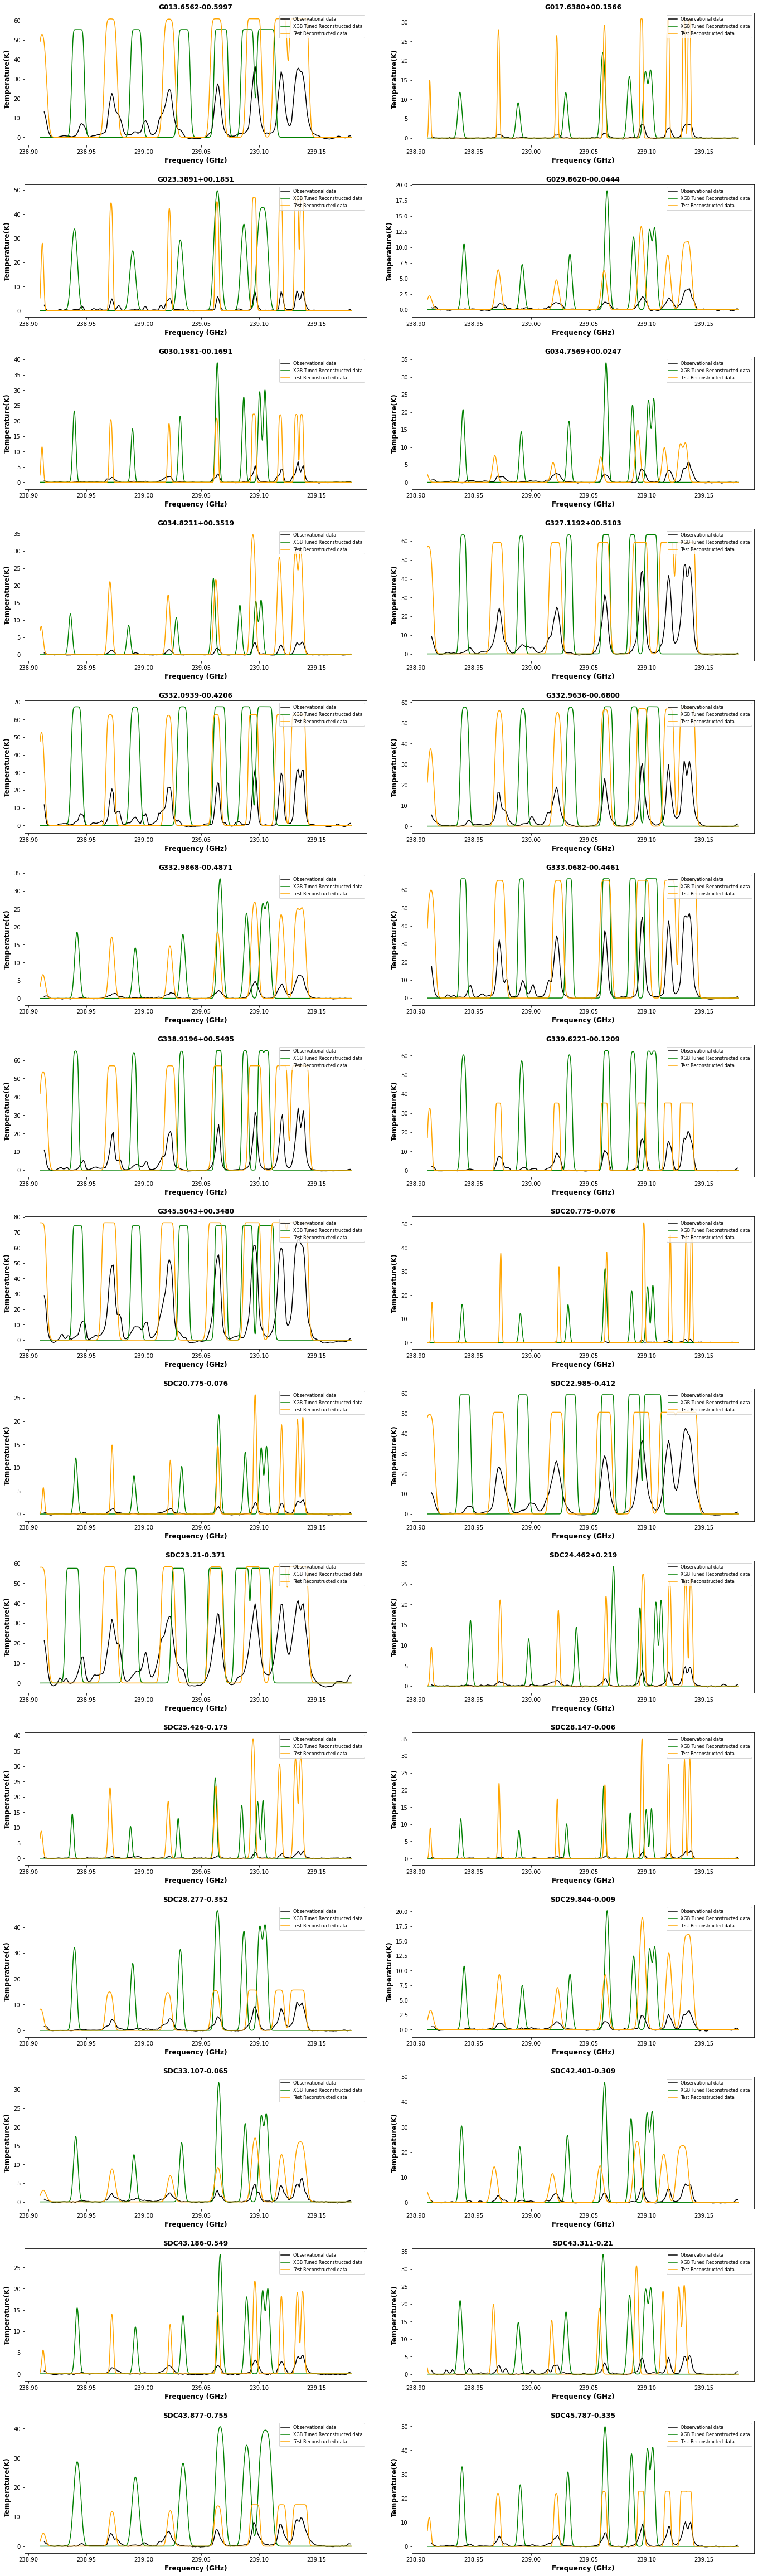

In [12]:
def plot_observational_reconstructed_data(CH3CN_DATA_PATH, RF_RECONSTRUCTED_PATH, XGB_RECONSTRUCTED_PATH, XGB_TUNED_RECONSTRUCTED_PATH, TEST_RECONSTRUCTED_PATH):
    '''
    Plot the observatinal data and reconstructed data on the same plots and compare 
    '''
    observational_files  = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    observational_files = [file for file in observational_files if os.path.basename(file) not in unwanted_file_list]

    rf_reconstructed_files = sorted(glob.glob(RF_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
    xgb_reconstructed_files = sorted(glob.glob(XGB_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
    xgb_tuned_reconstructed_files = sorted(glob.glob(XGB_TUNED_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
    test_reconstructed_files = sorted(glob.glob(TEST_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
    # reconstructed_files = [file for file in reconstructed_files if os.path.basename(file) not in unwanted_file_list]
    fig, ax = plt.subplots(nrows=15, ncols=2, figsize=(20, 65))
    fig.tight_layout(pad=5)

    for axn, obs_file,rf_recon_file, xgb_recon_file, xgb_tuned_recon_file, test_recon_file  in zip(ax.flatten(), sorted(observational_files), sorted(rf_reconstructed_files), sorted(xgb_reconstructed_files), sorted(xgb_tuned_reconstructed_files), sorted(test_reconstructed_files)):
        observational_df = pd.read_csv(obs_file, delim_whitespace=True)
        observational_df.drop(observational_df.columns[-1], axis=1, inplace=True)
        observational_df.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        observational_df['RestFreq(GHz)'] = observational_df['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        observational_df = observational_df[(observational_df['RestFreq(GHz)'] >= 238.60) & (observational_df['RestFreq(GHz)'] <= 239.18)]
    
        # set row one of the dataframe to be equal to 238.60 GHz and 0.00 for the temperature
        # row_one_vals = pd.DataFrame({"RestFreq(Hz)": 2.386e+11, "RestFreq(GHz)": 238.60, "T(K)": 0.0}, index=[0])
        # observational_df2 = pd.concat([observational_df.iloc[:0], row_one_vals, observational_df.iloc[0:]]).reset_index(drop=True)
        
    
        x_obs = observational_df['RestFreq(GHz)']
        y_obs = observational_df['T(K)']
    
        # # new length of the data to match the length of the synthetic data
        # new_obs_length = 58000
        # # new x values
        # new_obs_x = np.linspace(x_obs.min(), x_obs.max(), new_obs_length)
        # # interpolate the original signal to have 454 points
        # new_obs_y = interpolate.interp1d(x_obs, y_obs, kind='cubic')(new_obs_x)  

        # # get the reconstructed data
        rf_reconstructed_df = pd.read_csv(rf_recon_file, delim_whitespace=True) 
        xgb_reconstructed_df = pd.read_csv(xgb_recon_file, delim_whitespace=True) 
        xgb_tuned_reconstructed_df = pd.read_csv(xgb_tuned_recon_file, delim_whitespace=True) 
        test_reconstructed_df = pd.read_csv(test_recon_file, delim_whitespace=True)
        # reconstructed_df = reconstructed_df[(reconstructed_df['RestFreq(GHz)'] > 238.91) & (reconstructed_df['RestFreq(GHz)'] < 239.18)]
        # print('Min RestFreq(GHz) = ', reconstructed_df['RestFreq(GHz)'].min(), 'Max RestFreq(GHz) = ', reconstructed_df['RestFreq(GHz)'].max())

        rf_x_recon = rf_reconstructed_df['RestFreq(GHz)']
        rf_y_recon = rf_reconstructed_df['T(K)']

        xgb_x_recon = xgb_reconstructed_df['RestFreq(GHz)']
        xgb_y_recon = xgb_reconstructed_df['T(K)']


        xgb_tuned_x_recon = xgb_tuned_reconstructed_df['RestFreq(GHz)']
        xgb_tuned_y_recon = xgb_tuned_reconstructed_df['T(K)']

        test_x_recon = test_reconstructed_df['RestFreq(GHz)']
        test_y_recon = test_reconstructed_df['T(K)']


        # plot the observational and reconstructed data
        axn.plot(x_obs, y_obs, color='black', label='Observational data')
        # axn.plot(rf_x_recon, rf_y_recon, color='blue', label='RF Reconstructed data')
        # axn.plot(xgb_x_recon, xgb_y_recon, color='red', label='XGB Reconstructed data')
        axn.plot(xgb_tuned_x_recon, xgb_tuned_y_recon, color='green', label='XGB Tuned Reconstructed data')
        axn.plot(test_x_recon, test_y_recon, color='orange', label='Test Reconstructed data')
        axn.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=12, fontweight='bold')
        axn.set_title(os.path.basename(obs_file).split('_')[0], fontsize=12, fontweight='bold')
        axn.legend(loc='upper right', fontsize=8)


plot_observational_reconstructed_data(CH3CN_DATA_PATH, RF_RECONSTRUCTED_PATH, XGB_RECONSTRUCTED_PATH, XGB_TUNED_RECONSTRUCTED_PATH, TEST_RECONSTRUCTED_PATH)
plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'test_observational_reconstructed_data.pdf', dpi=15000)

In [ ]:
# rf_reconstructed_df = pd.read_csv('data/observational/ch3cn_generated_files/rf_ch3cn_predicted_parameters.csv', names=['fwhm', 'ntot', 'size', 'tex', 'vlsr', 'filename']) 
# xgb_reconstructed_df = pd.read_csv('data/observational/ch3cn_generated_files/xgb_ch3cn_predicted_parameters.csv', names=['fwhm', 'ntot', 'size', 'tex', 'vlsr', 'filename']) 
# xgb_tuned_reconstructed_df = pd.read_csv('data/observational/ch3cn_generated_files/xgb_tuned_ch3cn_predicted_parameters.csv', names=['fwhm', 'ntot', 'size', 'tex', 'vlsr', 'filename']) 